 # Project 7 - Implémentation d'un Modèle de Scoring
 
 ## Part 3 of 4 - Le Modèle LGBM

# 1. Kaggle Resources

**Data:**
* https://www.kaggle.com/c/home-credit-default-risk/data

**Series of Notebooks detailing the Problem:**
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
* ...

**EDA:**
* https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda

**Feature Engineering:**
* https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

**Models/Scripts - Light_GBM**
* https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
* https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm

**DNN:**
https://www.kaggle.com/shep312/deep-learning-in-tf-with-upsampling-lb-758


# 2. Imports Bibliothèques

In [2]:
import os, re, gc

import pandas as pd
import numpy as np

In [51]:
import time

In [3]:
import joblib
import sys
import win32com.client 

In [4]:
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [80]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve, average_precision_score, log_loss
from sklearn.model_selection import KFold, cross_validate, train_test_split, GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.metrics import roc_auc_score, log_loss, f1_score, balanced_accuracy_score, average_precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay


from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
#from lightgbm import LGBMClassifier
#from lightgbm import cv as lgbm_cv
import lightgbm as lgbm

# 3. Fonctions

## 3.0 Import des Données

In [6]:
def get_shortcut_path(filepath):
    shell = win32com.client.Dispatch("WScript.Shell")
    shortcut = shell.CreateShortCut(filepath)
    return shortcut.Targetpath +'\\'

## 3.1 Le Modèle LGBM

### 3.1.1 Le modèle

In [53]:
def model_lgbm(X_train, X_test, y_train, n_folds=5):
    
    df_train = X_train.reset_index(drop=True)
    df_test = X_test.reset_index(drop=True)
    
    # Extract the labels for training
    y_labels = y_train.reset_index(drop=True)
    
    # Align the training and testing data, keep only columns present in both dataframes
    #df_train, df_test = df_train.align(df_test, join = 'inner', axis = 1)
    
    #Output information
    print('Training Data Shape: ', df_train.shape)
    print('Testing Data Shape: ', df_test.shape)
    
    # Extract feature names
    feature_names = list(df_train.columns)
    
    # Convert to np arrays
    df_train = np.array(df_train)
    df_test = np.array(df_test)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(df_test.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(df_train.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    time_scores = []
    
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(df_train):
        

        # Training data for the fold
        train_features, train_labels = df_train[train_indices], y_labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = df_train[valid_indices], y_labels[valid_indices]
        
        # Create the model
        model = lgbm.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        earlystop = lgbm.early_stopping(100, first_metric_only=False, verbose=True,)
        # Train the model
        tic = time.perf_counter()
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = 'auto',
                  callbacks=[earlystop])
        toc = time.perf_counter()

        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(df_test, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        time_scores.append(toc - tic)

        
        # Clean up memory
        gc.enable()
        del train_features, valid_features
        gc.collect()
    

        
    # Make the submission dataframe
    y_test_pred = pd.Series(test_predictions, name='TARGET')
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(y_labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    time_scores.append(np.mean(time_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    scores = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores,
                            'time': time_scores}) 
    
    return y_test_pred, feature_importances, scores, model

### 3.1.2 Affichage des Résultats

In [8]:
def plot_feature_importances(df, num=15, figsize=(10, 6), threshold = 0.9):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    

    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
        num (integer): number of top important features to plot
        
        figsize: size of the figures
        
        threshold (float: 0-1.0, default=0.9): Threshold for prining information about cumulative importances

        
    Returns:
        shows a plot of the "num" most importance features,
        prints the number of features needed to reach threshold cumulative importance,
        shows a plot of the cummalative importance

        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])


    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = figsize)
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:num]))), 
            df['importance_normalized'].head(num), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:num]))))
    ax.set_yticklabels(df['feature'].head(num))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

In [9]:
def output_lgbm_results(y_test_pred, y_test, fi, scores, threshold=0.9, ) :
    print('Baseline AUC scores')
    print(scores)
    print()
    print("The value for the X_test set is :", roc_auc_score(y_test, y_test_pred))
    print()
    print('The 20 most important features are: ')
    
    fi_sorted = plot_feature_importances(fi, 20, (10,8), threshold)
    return fi_sorted

## 3.2 Scoring

In [64]:
def scores_from_model(model, X_test, y_test, scoring_tple):
    y_test_pred = model.predict_proba(X_test)
    score_dict={}
    for score in scoring_tple:
        if score == 'neg_log_loss':
            score_dict[score] = log_loss(y_test, y_test_pred)
        elif score == 'roc_auc':
            score_dict[score] = roc_auc_score(y_test, y_test_pred[:,1])
        elif score == 'average_precision':
            score_dict[score] = average_precision_score(y_test, y_test_pred[:,1].round())
        elif score == 'balanced_accuracy' :
            score_dict[score] = balanced_accuracy_score(y_test, y_test_pred[:,1].round())
        elif score == 'f1':
            score_dict[score] = f1_score(y_test, y_test_pred[:,1].round())
    return score_dict

In [56]:
model_dict={}

# 4. Import des Données

## 4.1 Les Features

In [11]:
PATH = os.path.dirname(os.getcwd())
DATAFOLDER = '\\Data\\'
filepath = PATH + DATAFOLDER
filename = 'features.csv'

features = pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])['features'].values

## 4.2 Le dataset

In [12]:
PATH = os.getcwd()
DATAFOLDER = '\\DataShortcut.lnk'
filepath = get_shortcut_path(PATH+DATAFOLDER)
filename = 'data_processed.csv'

dataset = pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])

In [13]:
y = dataset['TARGET']
client_ids = dataset['SK_ID_CURR']
X = dataset.filter(items=features)
del dataset
gc.collect()

0

# 5. Train/Test Dévision

In [14]:
print(f"{len(X[y==1])} clients in the dataset defaulted, {len(X[y==0])} did not.")
print(f"That's {round(100*len(X[y==1])/len(X), 2)}%.")

24825 clients in the dataset defaulted, 282686 did not.
That's 8.07%.


## 5.1 Train/Test Dévision

In [15]:
test_size = 0.3
seed = 33
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(X, y, client_ids,
                                                                         test_size = test_size, random_state = seed, stratify=y)

## 5.2 Sous-échantillonnage de la classe majoritaire

In [16]:
undersample = True
min_size = len(X_train[y_train==1])
if undersample :
    #undersample manually
    select = list(X_train[y_train==0].sample(min_size, random_state=22).index.values) + list(X_train[y_train==1].index.values)
    X_under = X_train.loc[select, :]
    y_under = y_train.loc[select]
    ids_under = ids_train.loc[select]
    print(X_train.shape, X_under.shape, y_under.shape, min_size)
    #undersample with the module SMOTE
    rus = RandomUnderSampler(random_state=42)
    X_under, y_under = rus.fit_resample(X_train, y_train)
    print(X_train.shape, X_under.shape, y_under.shape, min_size)

(215257, 377) (34754, 377) (34754,) 17377
(215257, 377) (34754, 377) (34754,) 17377


# 6. Entraînement du Modèle LGBM

## 6.1 avec le dataset X_under

### 6.1.1 L'entrainement

In [54]:
y_test_pred, fi, scores, model = model_lgbm(X_under, X_test, y_under, n_folds=5)

Training Data Shape:  (34754, 377)
Testing Data Shape:  (92254, 377)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[242]	train's auc: 0.901138	train's binary_logloss: 0.442406	valid's auc: 0.781472	valid's binary_logloss: 0.563272
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[270]	train's auc: 0.909294	train's binary_logloss: 0.433608	valid's auc: 0.78572	valid's binary_logloss: 0.559469
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[278]	train's auc: 0.913367	train's binary_logloss: 0.426448	valid's auc: 0.772867	valid's binary_logloss: 0.571191
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[343]	train's auc: 0.929831	train's binary_logloss: 0.403875	valid's auc: 0.779456	valid's binary_logloss: 0.563724
Training until validation scores don't improve for 100 rounds
Early stopping, be

### 6.1.2 Résultats

Baseline AUC scores
      fold     train     valid      time
0        0  0.901138  0.781472  5.595827
1        1  0.909294  0.785720  5.862343
2        2  0.913367  0.772867  5.904776
3        3  0.929831  0.779456  7.523291
4        4  0.872768  0.772849  5.107360
5  overall  0.905279  0.778437  5.998719

The value for the X_test set is : 0.7771809219059724

The 20 most important features are: 


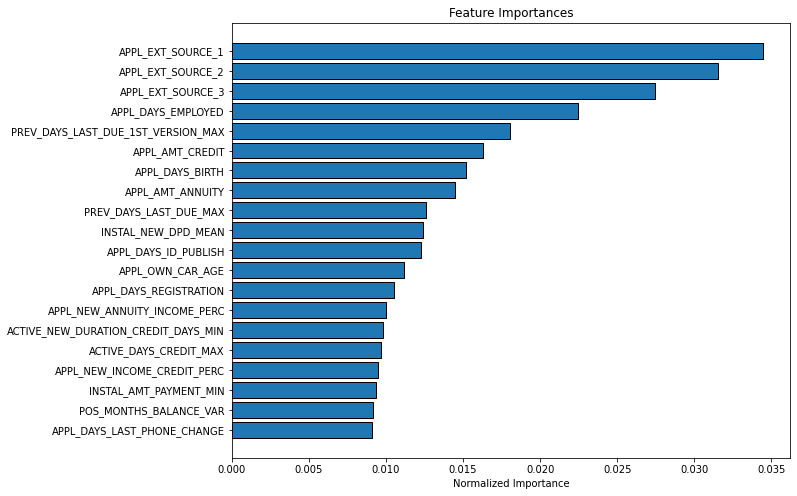

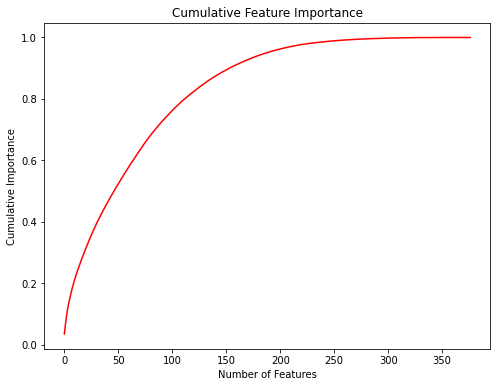

254 features required for 0.99 of cumulative importance


In [55]:
fi_sorted = output_lgbm_results(y_test_pred, y_test, fi, scores, threshold=0.99)

In [57]:
model_dict['X_under']=model

## 6.2 avec le dataset X_train

### 6.2.1 L'entrainement

In [58]:
y_test_pred, fi, scores, model = model_lgbm(X_train, X_test, y_train, n_folds=5)

Training Data Shape:  (215257, 377)
Testing Data Shape:  (92254, 377)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	train's auc: 0.876032	train's binary_logloss: 0.465719	valid's auc: 0.783893	valid's binary_logloss: 0.505372
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[233]	train's auc: 0.856141	train's binary_logloss: 0.487903	valid's auc: 0.776638	valid's binary_logloss: 0.52317
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[225]	train's auc: 0.851711	train's binary_logloss: 0.493232	valid's auc: 0.787985	valid's binary_logloss: 0.520201
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	train's auc: 0.84615	train's binary_logloss: 0.499445	valid's auc: 0.782668	valid's binary_logloss: 0.520396
Training until validation scores don't improve for 100 rounds
Early stopping, be

### 6.2.2 Résultats

Baseline AUC scores
      fold     train     valid       time
0        0  0.876032  0.783893  23.195365
1        1  0.856141  0.776638  20.684094
2        2  0.851711  0.787985  20.271291
3        3  0.846150  0.782668  17.942489
4        4  0.862902  0.773185  20.327196
5  overall  0.858587  0.780708  20.484087

The value for the X_test set is : 0.7805541369797999

The 20 most important features are: 


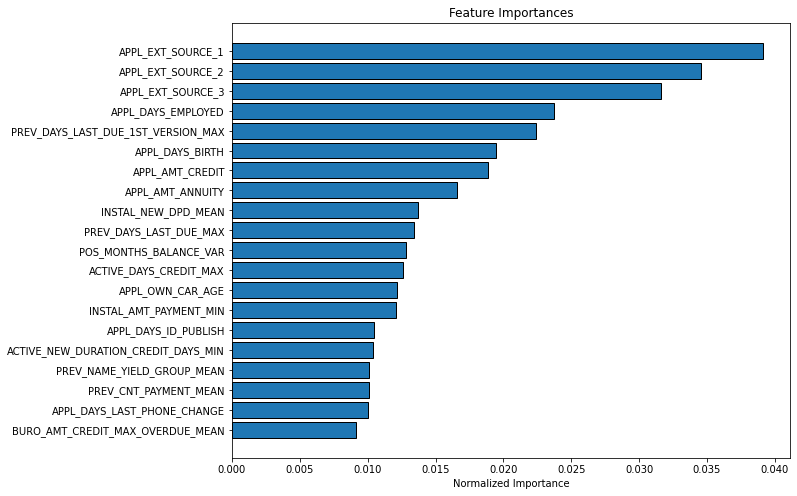

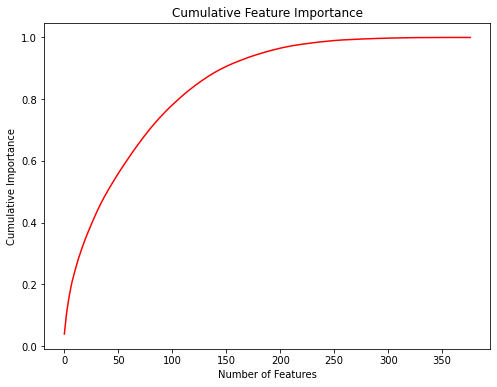

252 features required for 0.99 of cumulative importance


In [59]:
fi_sorted = output_lgbm_results(y_test_pred, y_test, fi, scores, threshold=0.99)

In [61]:
best_iteration = model.best_iteration_

In [62]:
print(f"The ROC AUC scores are:")
print(f"For all X data:\t\t {roc_auc_score(y, model.predict_proba(X, num_iteration=best_iteration)[:,1])}.")
print(f"For the X_train data:\t {roc_auc_score(y_train, model.predict_proba(X_train, num_iteration=best_iteration)[:,1])}.")
print(f"For the X_test data:\t {roc_auc_score(y_test, model.predict_proba(X_test, num_iteration=best_iteration)[:,1])}.")

The ROC AUC scores are:
For all X data:		 0.8249834653687791.
For the X_train data:	 0.8450404453519094.
For the X_test data:	 0.7779648333912697.


In [63]:
model_dict['X_train']=model

## 6.3 avec tout le dataset X

### 6.3.1 L'entrainement

In [115]:
y_test_pred, fi, scores, model = model_lgbm(X, X_test, y, n_folds=5)

Training Data Shape:  (307511, 556)
Testing Data Shape:  (92254, 556)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[307]	train's auc: 0.853861	train's binary_logloss: 0.488701	valid's auc: 0.785559	valid's binary_logloss: 0.516763
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	train's auc: 0.854455	train's binary_logloss: 0.487855	valid's auc: 0.785012	valid's binary_logloss: 0.516507
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[362]	train's auc: 0.863013	train's binary_logloss: 0.478552	valid's auc: 0.788197	valid's binary_logloss: 0.51224
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[357]	train's auc: 0.861894	train's binary_logloss: 0.479759	valid's auc: 0.787848	valid's binary_logloss: 0.510525
Training until validation scores don't improve for 100 rounds
Early stopping, b

### 6.3.2 Les Résultats

Baseline AUC scores
      fold     train     valid
0        0  0.853861  0.785559
1        1  0.854455  0.785012
2        2  0.863013  0.788197
3        3  0.861894  0.787848
4        4  0.880825  0.784460
5  overall  0.862810  0.786106

The value for the X_test set is : 0.8499397186750335

The 20 most important features are: 


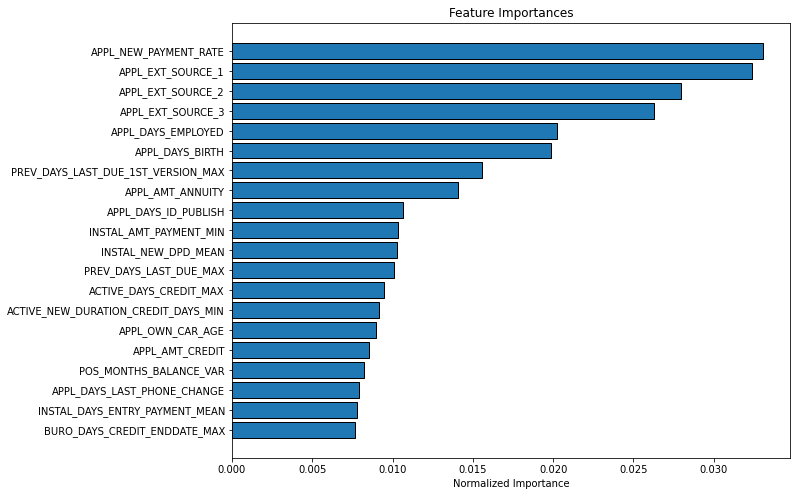

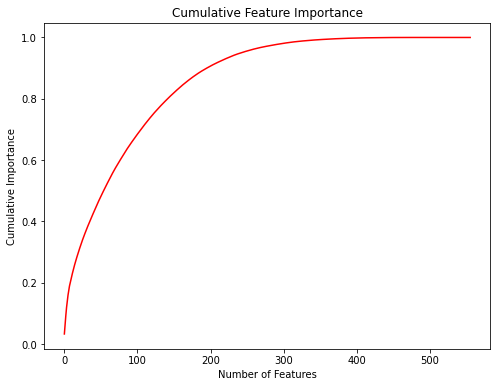

334 features required for 0.99 of cumulative importance


In [116]:
fi_sorted = output_lgbm_results(y_test_pred, y_test, fi, scores, threshold=0.99)

In [118]:
print(f"The ROC AUC scores are:")
print(f"For all X data:\t\t {roc_auc_score(y, model.predict_proba(X)[:,1])}.")
print(f"For the X_train data:\t {roc_auc_score(y_train, model.predict_proba(X_train)[:,1])}.")
print(f"For the X_test data:\t {roc_auc_score(y_test, model.predict_proba(X_test)[:,1])}.")

The ROC AUC scores are:
For all X data:		 0.8613800609416506.
For the X_train data:	 0.8624880515416573.
For the X_test data:	 0.8587890006515915.


## 6.4 Métrics d'Evaluation

In [66]:
scoring_tple = ('neg_log_loss', 'roc_auc', 'average_precision', 'balanced_accuracy', 'f1')

In [67]:
estimator = model_dict['X_train']
y_test_pred = estimator.predict_proba(X_test)

In [70]:
print(f'The log loss score for the X_test set is\t {log_loss(y_test, y_test_pred)}')
print(f'The ROC AUC score for the X_test set is\t\t {roc_auc_score(y_test, y_test_pred[:,1])}')
print(f'The bal. accuracy score for the X_test set is\t {balanced_accuracy_score(y_test, y_test_pred[:,1].round())}')
print(f'The f1 score for the X_test set is\t\t {f1_score(y_test, y_test_pred[:,1].round())}')

The log loss score for the X_test set is	 0.5153078978645732
The ROC AUC score for the X_test set is		 0.7779648333912697
The bal. accuracy score for the X_test set is	 0.7076143179683521
The f1 score for the X_test set is		 0.293452661328309


In [71]:
test_scores = scores_from_model(estimator, X_test, y_test, scoring_tple)
test_scores

{'neg_log_loss': 0.5153078978645732,
 'roc_auc': 0.7779648333912697,
 'average_precision': 0.15246897060362524,
 'balanced_accuracy': 0.7076143179683521,
 'f1': 0.293452661328309}

### 6.4.1 Matrix de Confusion

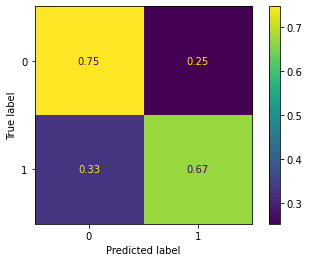

In [91]:
cm = confusion_matrix(y_test, y_test_pred[:,1].round(), normalize='true')
cm_display = ConfusionMatrixDisplay(cm).plot()

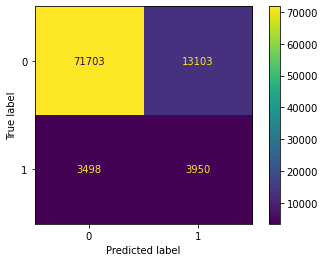

In [100]:
threshold = 0.6
y_test_pred_adj = [0 if y<threshold else 1 for y in y_test_pred[:,1] ]
cm = confusion_matrix(y_test, y_test_pred_adj)
cm_display = ConfusionMatrixDisplay(cm).plot()

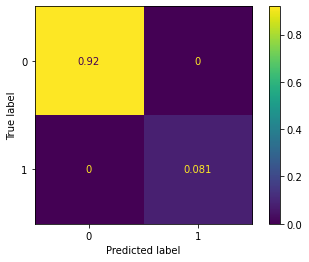

In [90]:
cm = confusion_matrix(y_test, y_test, normalize='all')
cm_display = ConfusionMatrixDisplay(cm).plot()

## 6.5 Export du Modèle

In [72]:
modelname = 'LGBM'
export_model = False
if export_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    joblib.dump(estimator, PATH + DATAFOLDER + modelname)

In [112]:
PATH = os.path.dirname(os.getcwd()) 
DATAFOLDER = '\\Data\\'
filepath = PATH+DATAFOLDER
filename = 'data_processed_min_min.csv'

dataset = pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])
X_min_min = dataset.filter(features)
cliend_ids_min_min = dataset['SK_ID_CURR']
y_min_min = dataset['TARGET']

In [118]:
y_pred_min_min = pd.DataFrame({'SK_ID_CURR': cliend_ids_min_min, 'PRED': estimator.predict_proba(X_min_min)[:,1]})

In [119]:
y_pred_min_min

,SK_ID_CURR,PRED
0,306189,0.244533
1,307064,0.531568
2,332985,0.198630
3,322721,0.509893
4,363918,0.093258
...,...,...
610,310627,0.113327
611,391676,0.246960
612,232666,0.096516
613,189815,0.087764


In [120]:
filename = 'LGBM_pred_min_min.csv'
export_pred = True
if export_pred:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    y_pred_min_min.to_csv(PATH+DATAFOLDER+filename)

In [108]:
y_pred_min_min

array([0.24453317, 0.53156782, 0.19862954, 0.50989294, 0.09325777,
       0.21008691, 0.1442598 , 0.55345426, 0.65934482, 0.2743384 ,
       0.02933682, 0.24620362, 0.07536558, 0.30521457, 0.73205526,
       0.46920907, 0.14135181, 0.73991195, 0.50861028, 0.59750961,
       0.31364595, 0.73802065, 0.28643138, 0.65444543, 0.7730815 ,
       0.59345788, 0.14503891, 0.468634  , 0.16181723, 0.56223917,
       0.45457687, 0.67334549, 0.5141175 , 0.43982842, 0.71717464,
       0.25718316, 0.15255018, 0.15922933, 0.14384565, 0.30982993,
       0.11975317, 0.18234766, 0.15753709, 0.11927903, 0.44024643,
       0.67228666, 0.53567695, 0.75600429, 0.17061325, 0.77397018,
       0.78896968, 0.23332583, 0.28931336, 0.66166334, 0.42921016,
       0.07255145, 0.6687403 , 0.26175144, 0.36702444, 0.22292746,
       0.08358275, 0.27109251, 0.5308082 , 0.3005442 , 0.1887061 ,
       0.31849142, 0.62216702, 0.21767292, 0.54896601, 0.48900599,
       0.16540927, 0.30733663, 0.1832041 , 0.58569073, 0.25561

## 6.6 Export des Feature Importances

In [78]:
fi

,feature,importance
0,APPL_NAME_CONTRACT_TYPE,24.0
1,APPL_CODE_GENDER,59.4
2,APPL_FLAG_OWN_CAR,1.0
3,APPL_FLAG_OWN_REALTY,1.2
4,APPL_CNT_CHILDREN,1.2
...,...,...
372,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,0.6
373,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,3.8
374,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,3.8
375,CLOSED_CNT_CREDIT_PROLONG_SUM,0.2


In [79]:
filename = 'LGBM_fi.csv'
export_model = True
if export_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    fi.to_csv(PATH+DATAFOLDER+filename)

# 7 Explorations des Features

## 7.1 les feature importances du modèle

In [77]:
estimator.feature_importances_.shape

(377,)

### 7.1.1 Features avec une importance == 0

In [73]:
fi_sorted[fi_sorted['importance_normalized'] == 0]['feature']

345                           APPL_NAME_TYPE_SUITE_Other
346       PREV_LOAN_PURPOSE_Car_repairs__accessories_SUM
347                                  APPL_FLAG_EMP_PHONE
348                        CLOSED_CREDIT_DAY_OVERDUE_MAX
349                  APPL_ORGANIZATION_TYPE_Trade_type_7
350        APPL_FONDKAPREMONT_MODE_reg_oper_spec_account
351                      PREV_NAME_CONTRACT_TYPE_XNA_SUM
352                PREV_NAME_SELLER_INDUSTRY_Tourism_SUM
353    PREV_NAME_PRODUCT_TYPE_POS_other_with_interest...
354                PREV_NAME_SELLER_INDUSTRY_Jewelry_SUM
355               PREV_NAME_SELLER_INDUSTRY_Industry_SUM
356    PREV_NAME_PRODUCT_TYPE_POS_mobile_without_inte...
357               APPL_ORGANIZATION_TYPE_Industry_type_3
358                 PREV_CODE_CONTRACT_STATUS_SYSTEM_SUM
359    POS_NAME_CONTRACT_STATUS_Returned_to_the_store...
360         PREV_LOAN_PURPOSE_Construction_Materials_SUM
361        PREV_LOAN_PURPOSE_Payments_on_other_loans_SUM
362                       APPL_

### 7.1.2 Explorations des Feature Groups

In [74]:
featuretype = 'APPL'
print(featuretype, 
      100 * fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['importance'].sum() / (fi_sorted['importance'].sum()))
display(fi_sorted[fi_sorted['feature'].str.startswith(featuretype)][:50])

APPL 33.274288781535155


,index,feature,importance,importance_normalized,cumulative_importance
0,28,APPL_EXT_SOURCE_1,291.8,0.039157,0.039157
1,29,APPL_EXT_SOURCE_2,257.6,0.034568,0.073725
2,30,APPL_EXT_SOURCE_3,235.6,0.031616,0.105341
3,10,APPL_DAYS_EMPLOYED,176.6,0.023698,0.129039
5,9,APPL_DAYS_BIRTH,144.8,0.019431,0.170907
6,6,APPL_AMT_CREDIT,140.4,0.018841,0.189748
7,7,APPL_AMT_ANNUITY,123.6,0.016586,0.206334
12,13,APPL_OWN_CAR_AGE,90.6,0.012158,0.271041
14,12,APPL_DAYS_ID_PUBLISH,78.2,0.010494,0.293612
18,41,APPL_DAYS_LAST_PHONE_CHANGE,74.6,0.010011,0.334138


In [75]:
featuretype = 'PREV'
print(featuretype, 
      100 * fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['importance'].sum() / (fi_sorted['importance'].sum()))
display(fi_sorted[fi_sorted['feature'].str.startswith(featuretype)][:50])

PREV 25.193236714975846


,index,feature,importance,importance_normalized,cumulative_importance
4,143,PREV_DAYS_LAST_DUE_1ST_VERSION_MAX,167.2,0.022437,0.151476
9,144,PREV_DAYS_LAST_DUE_MAX,100.0,0.013419,0.233468
16,139,PREV_NAME_YIELD_GROUP_MEAN,75.0,0.010064,0.314063
17,140,PREV_CNT_PAYMENT_MEAN,75.0,0.010064,0.324128
24,118,PREV_NEW_APPL_CREDIT_PERC_MEAN,62.0,0.008320,0.386339
33,136,PREV_SELLERPLACE_AREA_MEAN,53.6,0.007193,0.456092
36,116,PREV_NEW_APPL_CREDIT_PERC_MIN,50.0,0.006710,0.476758
37,121,PREV_AMT_DOWN_PAYMENT_MAX,48.4,0.006495,0.483253
38,225,PREV_CODE_CONTRACT_STATUS_APPROVED_MEAN,47.0,0.006307,0.489560
47,110,PREV_AMT_ANNUITY_MIN,42.6,0.005717,0.542754


# 8. Courbe d'Apprentissage

In [88]:
learning_curve_dict = {}

for test_size in np.linspace(0.1, 0.9, 9):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = seed, stratify=y)
    name = "Test_"+str(round(100*test_size))
    y_test_pred, fi, scores, model = model_lgbm(X_train, X_test, y_train, n_folds=5)
    train_scores = scores['train'].values
    valid_scores = scores['valid'].values
    test_score = roc_auc_score(y_test, y_test_pred)

    learning_curve_dict[name] = train_scores, valid_scores, test_score

Training Data Shape:  (276759, 556)
Testing Data Shape:  (30752, 556)
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	train's auc: 0.86238	train's binary_logloss: 0.479476	valid's auc: 0.784705	valid's binary_logloss: 0.511004
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[340]	train's auc: 0.865447	train's binary_logloss: 0.476188	valid's auc: 0.783942	valid's binary_logloss: 0.512688
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[382]	train's auc: 0.871808	train's binary_logloss: 0.469236	valid's auc: 0.788577	valid's binary_logloss: 0.504327
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[422]	train's auc: 0.879443	train's binary_logloss: 0.459651	valid's auc: 0.784348	valid's binary_logloss: 0.499771
Training until validation scores don't improve for 100 rounds
Early stopping, b

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	train's auc: 0.900453	train's binary_logloss: 0.447722	valid's auc: 0.777276	valid's binary_logloss: 0.495859
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	train's auc: 0.90529	train's binary_logloss: 0.440415	valid's auc: 0.782355	valid's binary_logloss: 0.487502
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	train's auc: 0.919989	train's binary_logloss: 0.418191	valid's auc: 0.789628	valid's binary_logloss: 0.473919
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[129]	train's auc: 0.908914	train's binary_logloss: 0.433991	valid's auc: 0.776056	valid's binary_logloss: 0.482439
Training Data Shape:  (30751, 556)
Testing Data Shape:  (276760, 556)
Training until validation scores don't improve for 100 rounds
Early stopping, b

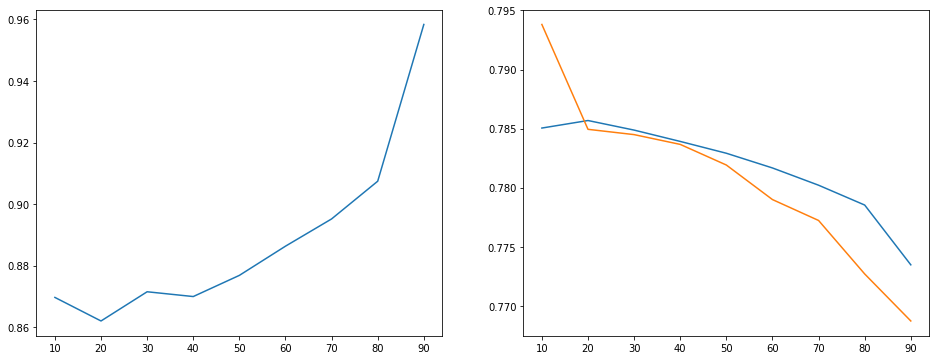

In [89]:
test_sizes = []
test_scores = [] 
train_scores = []
valid_scores = []
for key, tup in learning_curve_dict.items():
    test_sizes.append(int(key.replace('Test_', '')))
    train_scores.append(tup[0][-1])
    valid_scores.append(tup[1][-1])
    test_scores.append(tup[2])
fig, axs = plt.subplots(1,2, figsize=(16,6))
axs[0].plot(test_sizes, train_scores)
axs[1].plot(test_sizes, valid_scores)
axs[1].plot(test_sizes, test_scores)
#plt.ylim(0.77, 0.80)